<a href="https://colab.research.google.com/github/BilyHakim/Machine-Learning/blob/main/Model_Nudity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepared Dataset

In [ ]:
pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1ZHHrIfMY-VY3gZifV3ggV74U5-_0ODIW

Downloading...
From: https://drive.google.com/uc?id=1ZHHrIfMY-VY3gZifV3ggV74U5-_0ODIW
To: /content/dataset.zip
100% 3.63G/3.63G [00:37<00:00, 96.7MB/s]


In [ ]:
!unzip /content/dataset.zip -d /content

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu002-olQit3y.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu003-TxJ0fby.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu004-YzdVpOT.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu005-BD02XTH.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789001-F9McLXe.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789002-6mDNuDv.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789003-9Px5MWq.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789004-7PunV9e.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789005-VPjPJRF.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789006-j1CYnbr.jpg.jpeg  
  inflating: /content/dataset/t

In [ ]:
# Mengatur path ke dataset Anda
train_dir = '/content/dataset/training'
valid_dir = '/content/dataset/validation'
test_dir = '/content/dataset/testing'

## InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.utils import get_file

In [ ]:
# Set the weights file URL
weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# Set the local path to save the weights file
local_weights_file = get_file('inception_v3_weights.h5', weights_url, cache_dir='/tmp/', cache_subdir='models')

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), 
                               include_top=False, 
                               weights=None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( valid_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
# Menggunakan Metode early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Set the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Train the model.
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/20
100/100 - 112s - loss: 0.4387 - accuracy: 0.8255 - val_loss: 0.4046 - val_accuracy: 0.8410 - 112s/epoch - 1s/step
Epoch 2/20
100/100 - 102s - loss: 0.2703 - accuracy: 0.8905 - val_loss: 0.4581 - val_accuracy: 0.8380 - 102s/epoch - 1s/step
Epoch 3/20
100/100 - 100s - loss: 0.3100 - accuracy: 0.8815 - val_loss: 0.5386 - val_accuracy: 0.8080 - 100s/epoch - 998ms/step
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


100/100 - 87s - loss: 0.2599 - accuracy: 0.8990 - val_loss: 0.5111 - val_accuracy: 0.8160 - 87s/epoch - 869ms/step


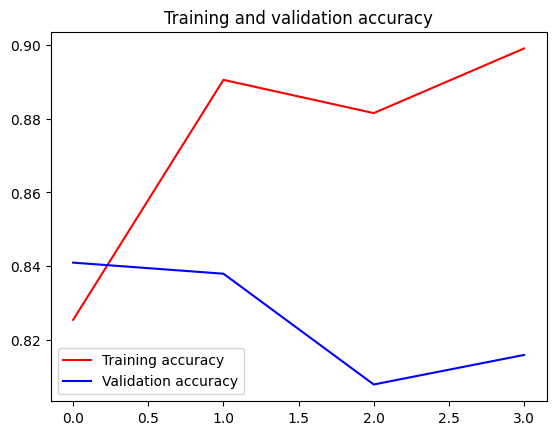

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Evaluasi model pada data pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 3750 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

118/118 [==============================] - 34s 279ms/step - loss: 0.7239 - accuracy: 0.7584
Test loss: 0.7239370346069336
Test accuracy: 0.758400022983551


### Prediksi Gambar

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np

In [ ]:
# Function to preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

In [ ]:
# Function to make predictions
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)

    # Threshold for classifying as NSFW
    nsfw_threshold = 0.5

    if predictions[0][0] <= nsfw_threshold:
        print("The image contains NSFW content.")
    else:
        print("The image is safe.")

In [ ]:
import os

# Path folder gambar
folder_path = "/content/dataset-testing"

# Mendapatkan daftar file dalam folder
file_list = os.listdir(folder_path)

# Loop untuk memprediksi setiap gambar
for file_name in file_list:
    # Membuat path lengkap ke file gambar
    image_file = os.path.join(folder_path, file_name)
    
    # Melakukan prediksi gambar
    prediction = predict_image(image_file)
    
    # Menampilkan hasil prediksi
    print(f"Prediction for {file_name}: {prediction}")

1/1 [==============================] - 2s 2s/step
The image contains NSFW content.
Prediction for 2.jpeg: None
1/1 [==============================] - 0s 36ms/step
The image is safe.
Prediction for 4.jpg: None
1/1 [==============================] - 0s 37ms/step
The image is safe.
Prediction for 5.jpg: None
1/1 [==============================] - 0s 36ms/step
The image contains NSFW content.
Prediction for 1.jpeg: None
1/1 [==============================] - 0s 38ms/step
The image contains NSFW content.
Prediction for 3.jpeg: None


## CNN (Convolutional Neural Network)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size = 32,
    class_mode='binary'
)

Found 17500 images belonging to 2 classes.


In [ ]:
# Data Generator untuk test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 3750 images belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Latih model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
117/547 [=====>........................] - ETA: 2:16 - loss: 0.6201 - accuracy: 0.6573

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


547/547 [==============================] - 208s 359ms/step - loss: 0.5454 - accuracy: 0.7214 - val_loss: 0.8153 - val_accuracy: 0.6104
Epoch 2/10
547/547 [==============================] - 154s 281ms/step - loss: 0.4392 - accuracy: 0.7947 - val_loss: 0.6611 - val_accuracy: 0.6917
Epoch 3/10
547/547 [==============================] - 166s 303ms/step - loss: 0.3836 - accuracy: 0.8282 - val_loss: 0.9398 - val_accuracy: 0.6517
Epoch 4/10
547/547 [==============================] - 151s 276ms/step - loss: 0.3430 - accuracy: 0.8501 - val_loss: 1.0543 - val_accuracy: 0.6453
Epoch 5/10
547/547 [==============================] - 151s 276ms/step - loss: 0.3095 - accuracy: 0.8693 - val_loss: 0.6873 - val_accuracy: 0.7424
Epoch 6/10
547/547 [==============================] - 151s 276ms/step - loss: 0.2792 - accuracy: 0.8824 - val_loss: 0.7640 - val_accuracy: 0.7272
Epoch 7/10
547/547 [==============================] - 151s 277ms/step - loss: 0.2659 - accuracy: 0.8885 - val_loss: 0.7659 - val_accura

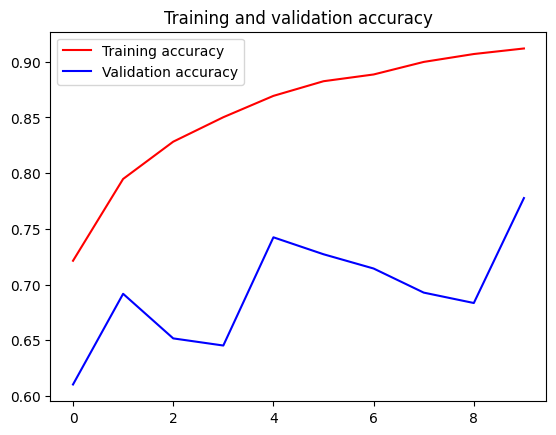

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

### Prediksi Gambar

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np

In [ ]:
# Function to preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

In [ ]:
# Function to make predictions
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)

    # Threshold for classifying as NSFW
    nsfw_threshold = 0.5

    if predictions[0][0] <= nsfw_threshold:
        print("The image contains NSFW content.")
    else:
        print("The image is safe.")

In [ ]:
import os

# Path folder gambar
folder_path = "/content/dataset-training"

# Mendapatkan daftar file dalam folder
file_list = os.listdir(folder_path)

# Loop untuk memprediksi setiap gambar
for file_name in file_list:
    # Membuat path lengkap ke file gambar
    image_file = os.path.join(folder_path, file_name)
    
    # Melakukan prediksi gambar
    prediction = predict_image(image_file)
    
    # Menampilkan hasil prediksi
    print(f"Prediction for {file_name}: {prediction}")

1/1 [==============================] - 0s 293ms/step
The image contains NSFW content.
Prediction for 2.jpeg: None
1/1 [==============================] - 0s 20ms/step
The image contains NSFW content.
Prediction for 4.jpg: None
1/1 [==============================] - 0s 17ms/step
The image contains NSFW content.
Prediction for 5.jpg: None
1/1 [==============================] - 0s 17ms/step
The image contains NSFW content.
Prediction for 1.jpeg: None
1/1 [==============================] - 0s 19ms/step
The image contains NSFW content.
Prediction for 3.jpeg: None


## InceptionResNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada saat pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Menggunakan ImageDataGenerator untuk memuat dan mempersiapkan data latihan dan validasi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=25,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=25,
    class_mode='binary'
)

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
# Membangun model InceptionResNetV2 tanpa lapisan top
base_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# Menambahkan lapisan klasifikasi di atas model dasar
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Mengompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
# Melatih model dengan data latihan dan validasi
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    verbose = 2 // Menambahkan Verbose
)

Epoch 1/10
700/700 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9583

700/700 [==============================] - 592s 846ms/step - loss: 0.1168 - accuracy: 0.9583 - val_loss: 0.7988 - val_accuracy: 0.8208
Epoch 2/10
700/700 [==============================] - 331s 472ms/step - loss: 0.1163 - accuracy: 0.9583
Epoch 3/10
700/700 [==============================] - 331s 473ms/step - loss: 0.1122 - accuracy: 0.9598
Epoch 4/10
700/700 [==============================] - 331s 473ms/step - loss: 0.1012 - accuracy: 0.9636
Epoch 5/10
700/700 [==============================] - 329s 469ms/step - loss: 0.0856 - accuracy: 0.9693
Epoch 6/10
700/700 [==============================] - 329s 469ms/step - loss: 0.0864 - accuracy: 0.9694
Epoch 7/10
700/700 [==============================] - 327s 467ms/step - loss: 0.0763 - accuracy: 0.9722
Epoch 8/10
700/700 [==============================] - 327s 467ms/step - loss: 0.0751 - accuracy: 0.9729
Epoch 9/10
700/700 [==============================] - 327s 466ms/step - loss: 0.0692 - accuracy: 0.9754
Epoch 10/10
700/700 [============

ValueError: ignored

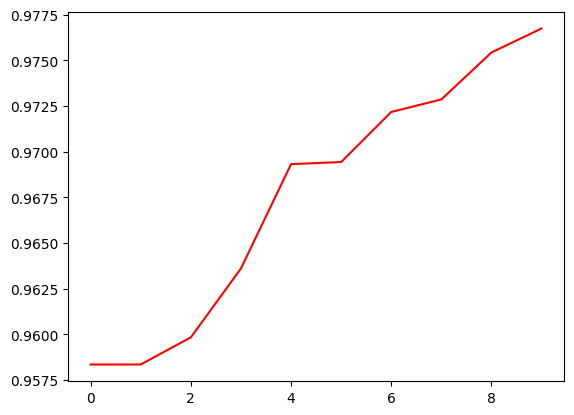

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Evaluasi model pada data pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=25,
    class_mode='binary',
    shuffle=False
)

Found 3750 images belonging to 2 classes.


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

150/150 [==============================] - 38s 251ms/step - loss: 0.7506 - accuracy: 0.7696
Test Loss: 0.7506251335144043
Test Accuracy: 0.769599974155426


## Resnet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada saat pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Menggunakan ImageDataGenerator untuk memuat dan mempersiapkan data latihan dan validasi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=25,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=25,
    class_mode='binary'
)

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
# Load model ResNet50 dengan menggunakan pre-trained weights pada 'imagenet'
base_model = ResNet50(weights='imagenet', include_top=False)

# Buat arsitektur model baru dengan menambahkan layer kustom di atas ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Freeze weights pada model ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Latih model menggunakan data training
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples,
    validation_data=valid_generator,
    # validation_steps=valid_generator.samples,
    epochs=10,
    verbose=2
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700/700 - 484s - loss: 0.5863 - accuracy: 0.6794 - val_loss: 0.7229 - val_accuracy: 0.6587 - 484s/epoch - 692ms/step
Epoch 2/10
700/700 - 461s - loss: 0.5660 - accuracy: 0.7010 - val_loss: 0.8488 - val_accuracy: 0.5864 - 461s/epoch - 659ms/step
Epoch 3/10
700/700 - 460s - loss: 0.5551 - accuracy: 0.7118 - val_loss: 0.7279 - val_accuracy: 0.6653 - 460s/epoch - 657ms/step
Epoch 4/10
700/700 - 482s - loss: 0.5485 - accuracy: 0.7174 - val_loss: 0.7371 - val_accuracy: 0.6613 - 482s/epoch - 689ms/step
Epoch 5/10
700/700 - 477s - loss: 0.5438 - accuracy: 0.7202 - val_loss: 0.7563 - val_accuracy: 0.6645 - 477s/epoch - 681ms/step
Epoch 6/10
700/700 - 475s - loss: 0.5358 - accuracy: 0.7296 - val_loss: 0.6958 - val_accuracy: 0.6661 - 475s/epoch - 678ms/step
Epoch 7/10
700/700 - 468s - loss: 0.5262 - accuracy: 0.7368 - val_loss: 0.7596 - val_accuracy: 0.6675 - 468s/epoch - 669ms/step
Epoch 8/10
700/700 - 467s - loss: 0.5283 - accuracy: 0.7356 - val_loss: 0.7240 - val_accuracy: 0.6733 - 467s/epoch 

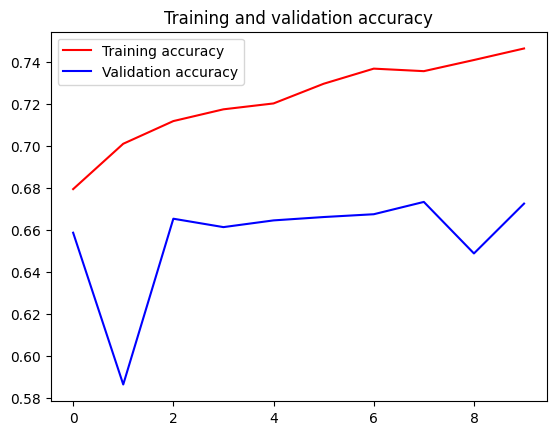

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Evaluasi model pada data pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=25,
    class_mode='binary',
    shuffle=False
)

Found 3750 images belonging to 2 classes.


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

150/150 [==============================] - 34s 224ms/step - loss: 0.9107 - accuracy: 0.6453
Test Loss: 0.9106707572937012
Test Accuracy: 0.6453333497047424


## Mobilenet V2

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Menentukan ukuran gambar input
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (img_width, img_height))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( valid_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_width, img_height))

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
# Memuat pre-trained MobileNetV2 model tanpa fully-connected layers
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Menambahkan fully-connected layers ke dalam model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan (Freeze) weights pada base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Mengkompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Melatih model dengan dataset training dan validation
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=validation_generator,
    verbose = 2
    # validation_steps=validation_generator.n // batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


875/875 - 501s - loss: 0.2231 - accuracy: 0.9135 - val_loss: 0.4402 - val_accuracy: 0.8520 - 501s/epoch - 572ms/step
Epoch 2/10
875/875 - 484s - loss: 0.1831 - accuracy: 0.9279 - val_loss: 0.4693 - val_accuracy: 0.8496 - 484s/epoch - 553ms/step
Epoch 3/10
875/875 - 469s - loss: 0.1716 - accuracy: 0.9337 - val_loss: 0.6214 - val_accuracy: 0.8267 - 469s/epoch - 536ms/step
Epoch 4/10
875/875 - 462s - loss: 0.1616 - accuracy: 0.9375 - val_loss: 0.5585 - val_accuracy: 0.8181 - 462s/epoch - 528ms/step
Epoch 5/10
875/875 - 478s - loss: 0.1531 - accuracy: 0.9427 - val_loss: 0.4762 - val_accuracy: 0.8552 - 478s/epoch - 546ms/step
Epoch 6/10
875/875 - 475s - loss: 0.1488 - accuracy: 0.9432 - val_loss: 0.5816 - val_accuracy: 0.8413 - 475s/epoch - 542ms/step
Epoch 7/10
875/875 - 479s - loss: 0.1413 - accuracy: 0.9446 - val_loss: 0.6005 - val_accuracy: 0.8168 - 479s/epoch - 547ms/step
Epoch 8/10
875/875 - 470s - loss: 0.1378 - accuracy: 0.9446 - val_loss: 0.7159 - val_accuracy: 0.8141 - 470s/epoch 

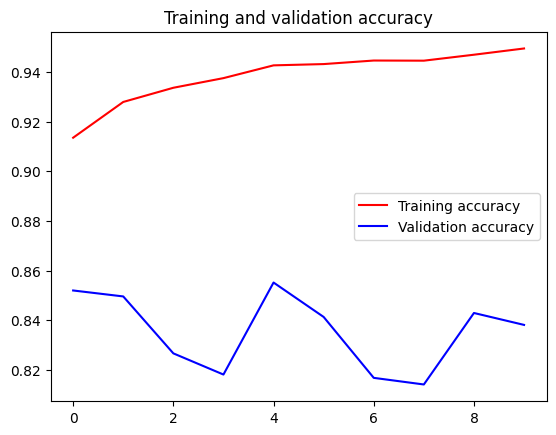

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Flow testing images in batches of 20 using test_datagen generator
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_width, img_height))

Found 3750 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

188/188 [==============================] - 34s 183ms/step - loss: 1.0474 - accuracy: 0.7509
Test loss: 1.0474365949630737
Test accuracy: 0.7509333491325378


## Transfer Learning Using NSFW Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [ ]:
# Tentukan batch size dan ukuran gambar yang diharapkan
batch_size = 32
image_size = (224, 224)
epochs = 10

In [ ]:
# Buat instance ImageDataGenerator untuk augmentasi data dan preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [ ]:
# Load model NSFW dari repositori
model = load_model('/content/nsfw_mobilenet2.224x224.h5')

# Menghapus layer terakhir dari model
model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Set bagian dari model agar tidak dilatih ulang (freeze)
for layer in model.layers:
    layer.trainable = False

In [ ]:
# Tambahkan layer output baru untuk klasifikasi 2 kategori
output = tf.keras.layers.Dense(1, activation='sigmoid')(model.output)

In [ ]:
# Bangun model baru berdasarkan model yang ada
model = tf.keras.Model(inputs=model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Buat generator untuk data training, testing, dan validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=2
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


547/547 - 534s - loss: 0.4248 - accuracy: 0.8505 - val_loss: 0.4027 - val_accuracy: 0.8488 - 534s/epoch - 976ms/step
Epoch 2/10
547/547 - 475s - loss: 0.3403 - accuracy: 0.8821 - val_loss: 0.3826 - val_accuracy: 0.8560 - 475s/epoch - 868ms/step
Epoch 3/10
547/547 - 479s - loss: 0.3343 - accuracy: 0.8842 - val_loss: 0.3712 - val_accuracy: 0.8629 - 479s/epoch - 876ms/step
Epoch 4/10
547/547 - 501s - loss: 0.3318 - accuracy: 0.8846 - val_loss: 0.3602 - val_accuracy: 0.8661 - 501s/epoch - 916ms/step
Epoch 5/10
547/547 - 529s - loss: 0.3304 - accuracy: 0.8880 - val_loss: 0.3524 - val_accuracy: 0.8680 - 529s/epoch - 967ms/step
Epoch 6/10
547/547 - 478s - loss: 0.3281 - accuracy: 0.8875 - val_loss: 0.3566 - val_accuracy: 0.8664 - 478s/epoch - 874ms/step
Epoch 7/10
547/547 - 476s - loss: 0.3270 - accuracy: 0.8878 - val_loss: 0.3513 - val_accuracy: 0.8699 - 476s/epoch - 870ms/step
Epoch 8/10
547/547 - 483s - loss: 0.3247 - accuracy: 0.8881 - val_loss: 0.3547 - val_accuracy: 0.8696 - 483s/epoch 

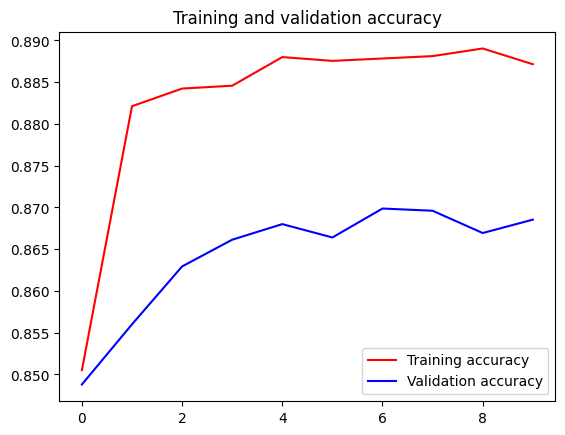

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Evaluasi model pada data testing
score = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

117/117 [==============================] - 35s 302ms/step - loss: 0.5657 - accuracy: 0.7585
Test Loss: 0.5657482147216797
Test Accuracy: 0.7585470080375671


In [ ]:
# Simpan model
model.save('content/image_classifier_model_NSFW_TL.pb')

In [ ]:
# Path to the save model
saved_model_dir = '/content/content/image_classifier_model_NSFW_TL.pb'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

In [ ]:
# Post Training Quantization
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

In [ ]:
import os
import zipfile

zip_name = 'tflite.zip'
zip_obj = zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED)

In [ ]:
source_folder = '/content/content/image_classifier_model_NSFW_TL.pb'
for foldername, subfolders, filenames in os.walk(source_folder):
    for filename in filenames:
        file_path = os.path.join(foldername, filename)
        zip_obj.write(file_path, os.path.relpath(file_path, source_folder))

zip_obj.close()